# When and Where do we bike in San Francisco? Ford GoBike Data Exploration
## by Maggie Kiraga

## Investigation Overview

> In this investigation, I wanted to look at the characteristics of rental bikes' history from the San Fransico area to get some insights about characteristics that might influence the biking behavior.

## Dataset Overview

> This dataset consists of 519,700 bike trips, spread over a period of approximately six months. The dataframe is made of 13 variables, where most of them are numeric in nature, providing information like rental location, duration, bike id, etc. 

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
trip_data = pd.read_csv('2017-fordgobike-tripdata.csv')

## Layout of the presentation
> In the following presentation we will take a closer look at the four variables of interest:
* rental duration
* distance between the start and end rental station
* rental stations, we will have a look at the most popular places in San Francisco
* weekday, describing the rental distribution throughout the week

> After we get familiar with the main distribution characters of each of those variables separately, we will explore how they interact with each other, to get a more complete understanding of the bike rentals. 

## What is the avreage rental time of a bike in SF?

> The plot below shows that most often rental time falls in intervals between 3 and 30 minutes, with a stepwise increase and the highest peak in the frequency when about 10 minutes. It seems that most of the GoBike customers are using bikes for short trips around the city, although there is a long thin tail of values on the right side of the figure. Meaning that a small portion of the users is renting the bikes even for hours. 

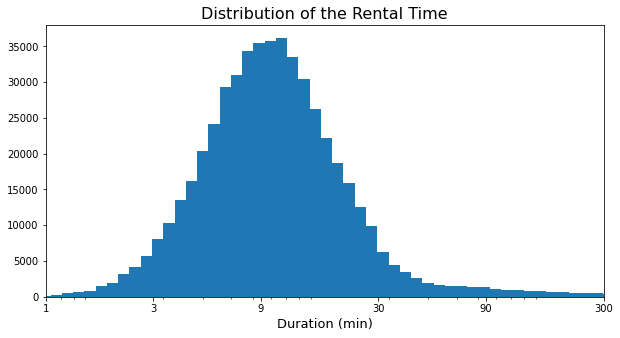

In [3]:
log_binsize = 0.05
bins = 10 ** np.arange(1.7, np.log10(trip_data['duration_sec'].max())+log_binsize, log_binsize)

plt.figure(figsize=[10, 5])
plt.hist(data = trip_data, x = 'duration_sec', bins = bins)
plt.xscale('log')
plt.xticks([60, 180, 540, 1800, 5400, 18000], [1, 3, 9, 30, 90, 300])
plt.xlabel('Duration (min)', fontsize=13)
plt.xlim((60,18000))
plt.title('Distribution of the Rental Time', fontsize=16)
plt.show()

## How far are the start and end station from each other? 

> The distance variable has its peak values around 1 km mark and is also characterized by the long right-sided tail, where the distances of 5km and above are highly rare. This is probably due to the fact that there are plenty of renting locations scattered around the whole city, giving customers a lot of options. Also, we can see that quite a lot of customers are bringing the bike to the same rental station. 

In [4]:
from math import cos, asin, sqrt, pi

def distance(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742 * asin(sqrt(a)) 

In [5]:
dist_v = np.vectorize(distance)
trip_data["distance"] = dist_v(
    trip_data.start_station_longitude,
    trip_data.start_station_latitude,
    trip_data.end_station_longitude,
    trip_data.end_station_latitude
)

In [6]:
high_outliers = (trip_data['distance'] > 6)
trip_data = trip_data.loc[-high_outliers,:]

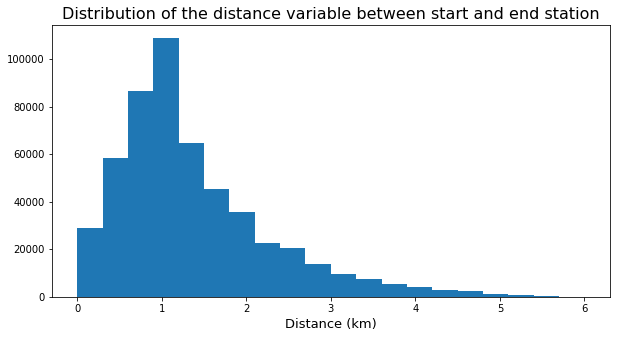

In [7]:
binsize = 0.3
bins = np.arange(0, trip_data['distance'].max()+binsize, binsize)

plt.figure(figsize=[10, 5])
plt.hist(data = trip_data, x = 'distance', bins = bins)
plt.xlabel('Distance (km)', fontsize=13)
plt.title('Distribution of the distance variable between start and end station', fontsize=16)
plt.show()

## Which are the most popular renting stations in SF?
> The below graph represents the top 10 rental stations in San Francisco. Most of the stations from this ranking are situated in close proximity to busy places, like city centrum or train stations. Another interesting fact is that three of the most popular start-renting stations are also the three most popular end-renting stations, although they are ranked in a different order. Later on, I will focus only on the top three starting locations, to simplify the interpretation of the results. 

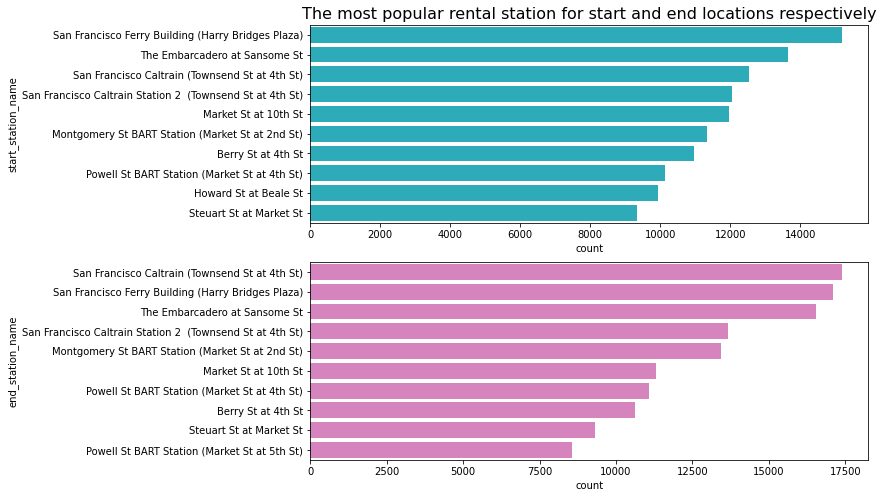

In [8]:
plt.figure(figsize = [10, 8])
blue = sb.color_palette()[9]
pink = sb.color_palette()[6]

plt.subplot(2, 1, 1)
# ordering the start start stations by their popularity
start_stations = trip_data['start_station_name'].value_counts()
# selecting the top 10 station with the highest count
top_start_stations = start_stations.index[:10]
trip_data_sub = trip_data.loc[trip_data['start_station_name'].isin(top_start_stations)]
sb.countplot(data=trip_data_sub, y='start_station_name', color=blue,
             order=trip_data_sub['start_station_name'].value_counts().index[:10])
plt.title('The most popular rental station for start and end locations respectively', fontsize=16)

plt.subplot(2, 1, 2)
end_stations = trip_data['end_station_name'].value_counts()
top_end_stations = end_stations.index[:10]
trip_data_sub = trip_data.loc[trip_data['end_station_name'].isin(top_end_stations)]
sb.countplot(data=trip_data_sub, y='end_station_name', color=pink,
            order=trip_data_sub['end_station_name'].value_counts().index[:10])
plt.show()

## On which days people bike the most? 
> It looks like the busiest days are Tuesday and Wednesday, being almost equally busy. Interestingly, the weekends are shown to be much less busy than the rest of the week, with Sunday's having the least number of customers. It makes sense, as we also saw above that bikes are usually rented for short periods of time, within the busiest areas of the city, suggesting that plenty of customers is renting a bike for practical purposes, like running an errand or getting to work. Another interesting observation is that the plots of start and end renting days look exactly the same, suggesting the same distribution of values. This was also quite intuitive, as we saw already most of the bike is rented for a few minutes/hours, and only a very trivial number of bikes was returned the next day.

In [9]:
trip_data['start_time'] = pd.to_datetime(arg=trip_data.start_time)
trip_data['end_time'] = pd.to_datetime(arg=trip_data.end_time)

In [10]:
# creating a list object with weekdays, ordered
week_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# adding week day columns into the dataframe using bulit-in weekday function
trip_data['week_day_start'] = trip_data.apply(lambda row: week_days[row["start_time"].weekday()], axis=1)
trip_data['week_day_end'] = trip_data.apply(lambda row: week_days[row["end_time"].weekday()], axis=1)

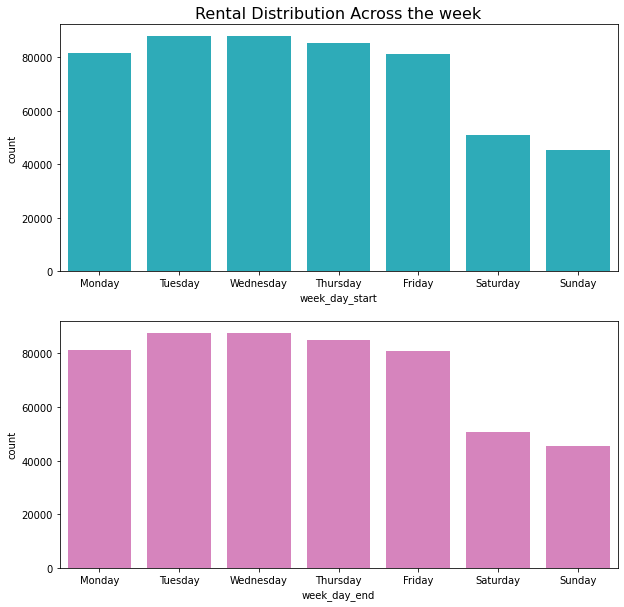

In [11]:
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
sb.countplot(data = trip_data, x='week_day_start', color=blue, order=week_days)
plt.title('Rental Distribution Across the week', fontsize=16)

plt.subplot(2,1,2)
sb.countplot(data = trip_data, x='week_day_end', color=pink, order=week_days)
plt.show()

## Does the rental frequency differs by rental place? 
> On the last figure we saw that the frequency of rentals during the week. The below figure explores if that distribution depends on the rental place. On the below figure we can see that the rental frequency follows the general pattern of more busy days during the working days and lesser frequencies at the weekends. Interesting is the fact that the differences between the Embarcadero at Sansome St station and the San Francisco Ferry Building station almost disappear at the weekends. The third station from the ranking: San Francisco Caltrain station is most of the time only half as busy as the other two stations. The busiest of the Caltrain station decreases drastically at the weekends, which might be explained by probably lower traffic in the closely situated train station. Whereas the other two stations from the ranking are situated in the close proximity to touristic and commercial areas, which might boost their popularity also in the weekends. 

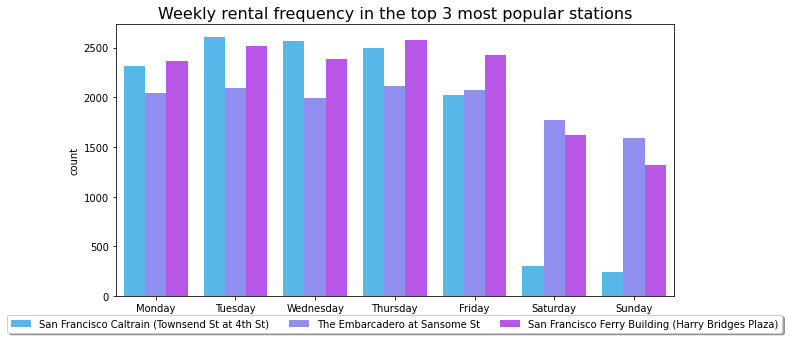

In [17]:
plt.figure(figsize=(10,5))
ax = plt.subplot(111)

top_3_stations = start_stations.index[:3]
trip_data_sub = trip_data.loc[trip_data['start_station_name'].isin(top_3_stations)]
sb.countplot(data=trip_data_sub, x='week_day_start', hue='start_station_name', order=week_days, palette='cool')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)
plt.title('Weekly rental frequency in the top 3 most popular stations', fontsize=16)
plt.show()

## How does the duration and distance of the rentals change during the week? 
> In the plots below we can observe the frequency of time and distance variables for a given day of the week. Because the univariate plots revealed that those two variables are having pretty long, right-skewed distribution, in the following plots the distinction was made between the extremely high and lower values of those variables. High duration times show a bit variability within the data with the longest rental time on Wednesdays and shortest on Saturdays. The low category is on contrary very stable across whole the days, with slightly higher rental time on the weekends. Similarly, the high and low category of the distance variable proved to be also very stable during the week. 

In [18]:
trip_data['duration_h'] = trip_data['duration_sec'] / 3600
trip_data['duration_values'] = np.where((trip_data['duration_sec'] >= 2700), 'High', 'Low')
trip_data['distance_values'] = np.where((trip_data['distance'] >= 2), 'High', 'Low')

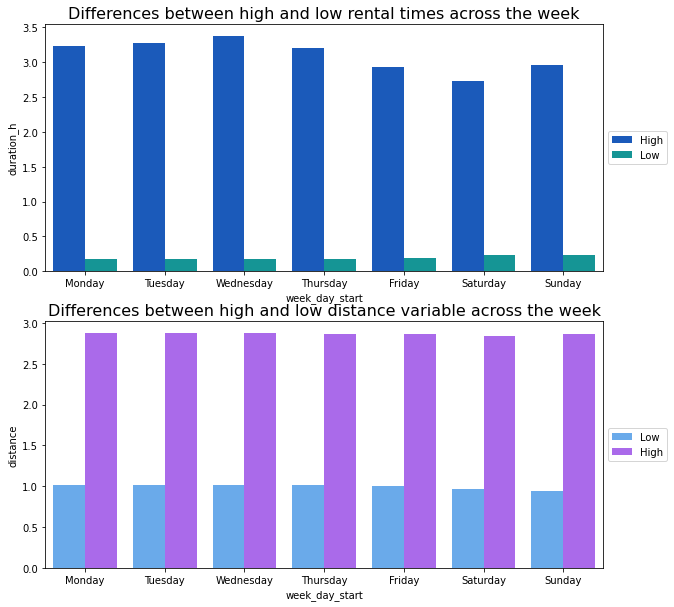

In [25]:
plt.figure(figsize=(10,10))

ax1 = plt.subplot(211)
sb.barplot(data=trip_data, x='week_day_start', y='duration_h', hue='duration_values', 
           order=week_days, palette='winter', ci=None)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Differences between high and low rental times across the week', fontsize=16)

ax2 = plt.subplot(212)
sb.barplot(data=trip_data, x='week_day_start', y='distance', hue='distance_values', 
           order=week_days, palette='cool', ci=None)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Differences between high and low distance variable across the week', fontsize=16)
plt.show()

## How distribution of the rental time changes within the week? Are there noticable differences between high and low duration values?
>  On the next figure, we can clearly see that there is a much higher number of rentals with low duration time and that there are fewer rentals on weekends than during the working days. Moreover, the distribution of the high rental time seems to be much equal during the whole week, with a much smaller variance than those rentals of low duration.

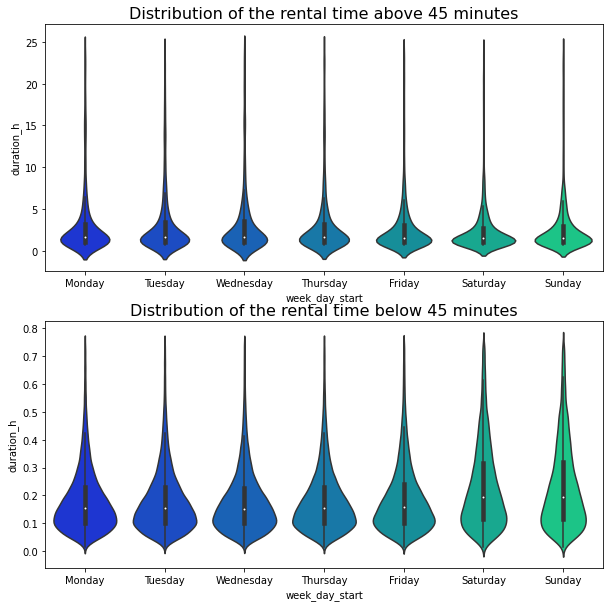

In [21]:
data_high_duration = trip_data.loc[trip_data['duration_values'] == 'High']

plt.figure(figsize=(10,10))

plt.subplot(211)
data_high_duration = trip_data.loc[trip_data['duration_values'] == 'High']
sb.violinplot(data=data_high_duration, x='week_day_start', y='duration_h', order=week_days, palette='winter')
plt.title('Distribution of the rental time above 45 minutes', fontsize=16)

plt.subplot(212)
data_low_duration = trip_data.loc[trip_data['duration_values'] == 'Low']
sb.violinplot(data=data_low_duration, x='week_day_start', y='duration_h', order=week_days, palette='winter')
plt.title('Distribution of the rental time below 45 minutes', fontsize=16)
plt.show()